In [46]:
import numpy as np
import matplotlib.pyplot as plt
from utils import get_formated_region_coords, rotate_region
from astroglial_analysis.classifier2 import classify_masks,visualize_classifications
from astroglial_analysis.pca import get_pcs, get_variance_direction
from astroglial_analysis.plot import plot_pcs
from astroglial_analysis.sub_segmentation import (subsegment_region,visualize_subsegments,subsegment_region_y_axis)
from astroglial_analysis.determine_line import (get_line,remove_outliers,best_fit_polynomial,align_regions)

In [47]:
p0 = r"..\..\tests\data\combined_mean_image1_seg.npy"
masks = np.load(p0, allow_pickle=True).item()["masks"]
# plt.figure(figsize=(20, 10))
# plt.imshow(masks)
# plt.gca().invert_yaxis()
# plt.show()

In [48]:

classifications, body, processes, body_and_processes = classify_masks(masks)
# visualize_classifications(masks=masks, classifications=classifications)
# plt.gca().invert_yaxis()

upper, lower = body_and_processes['upper'], body_and_processes['lower']


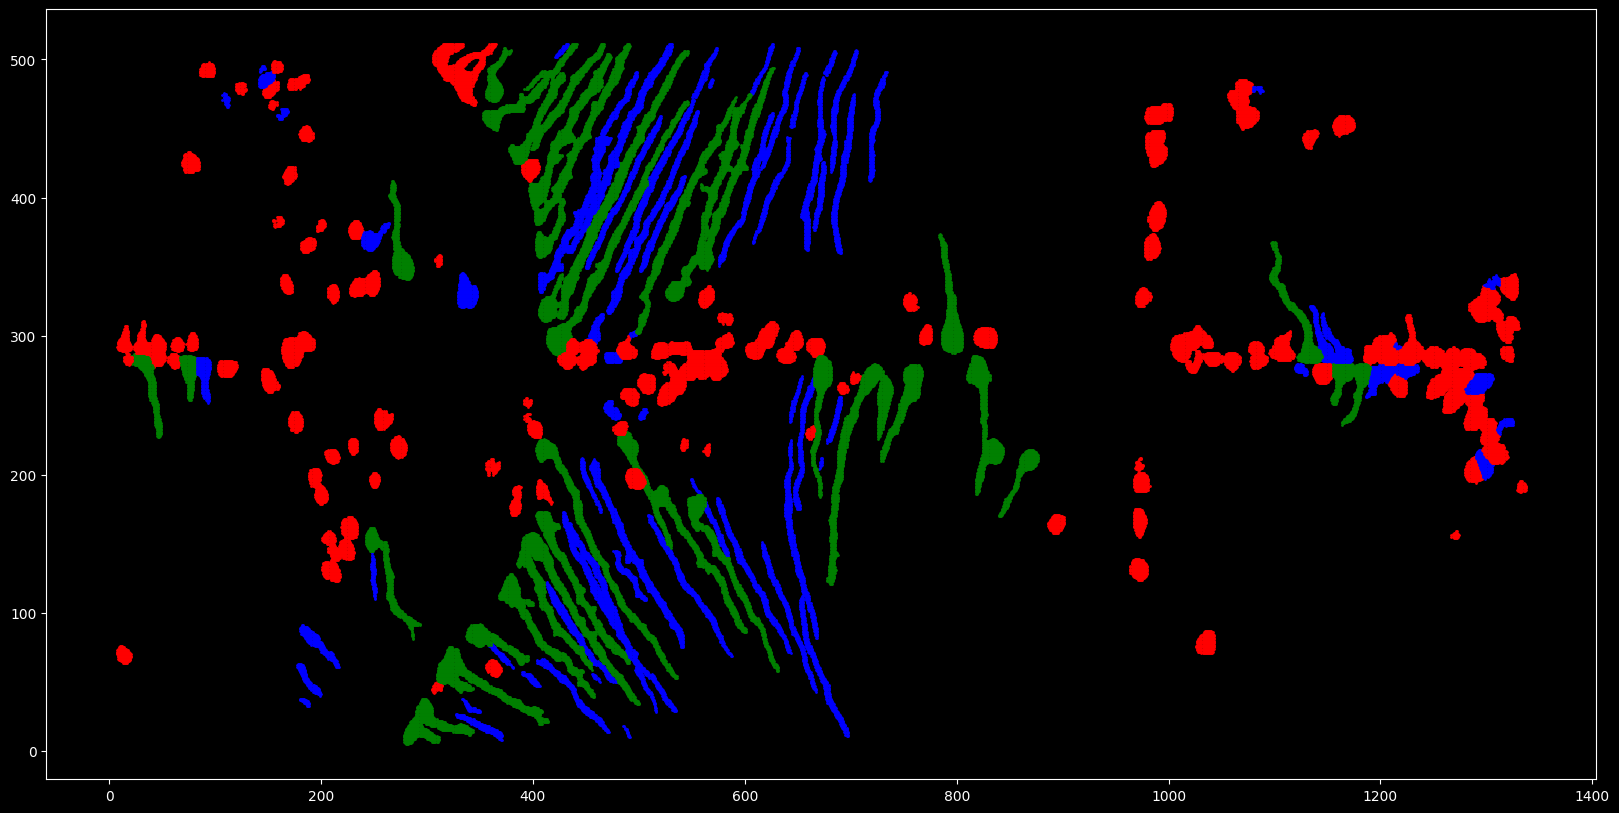

In [49]:
plt.figure(figsize=(20, 10))
visualize_classifications(masks=masks, classifications=classifications)
plt.show()

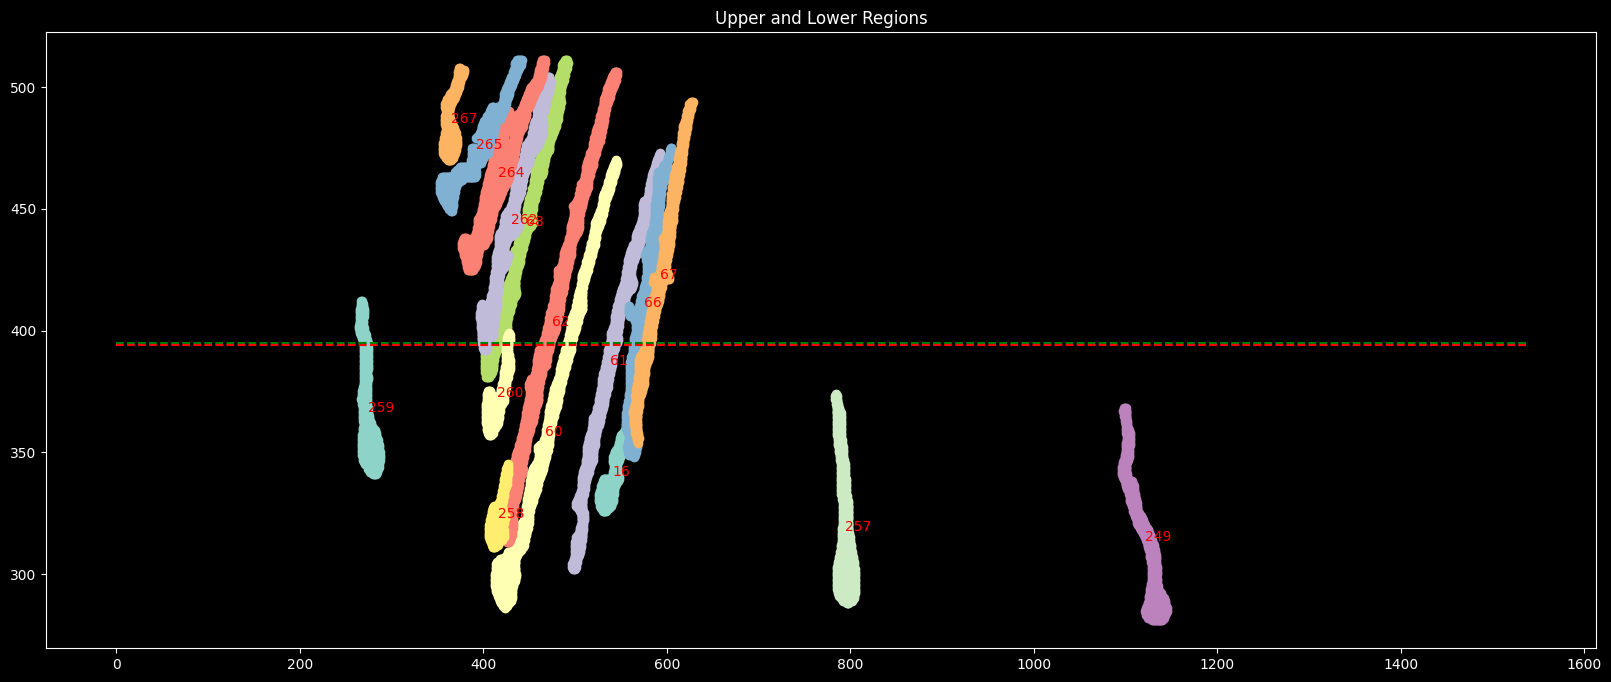

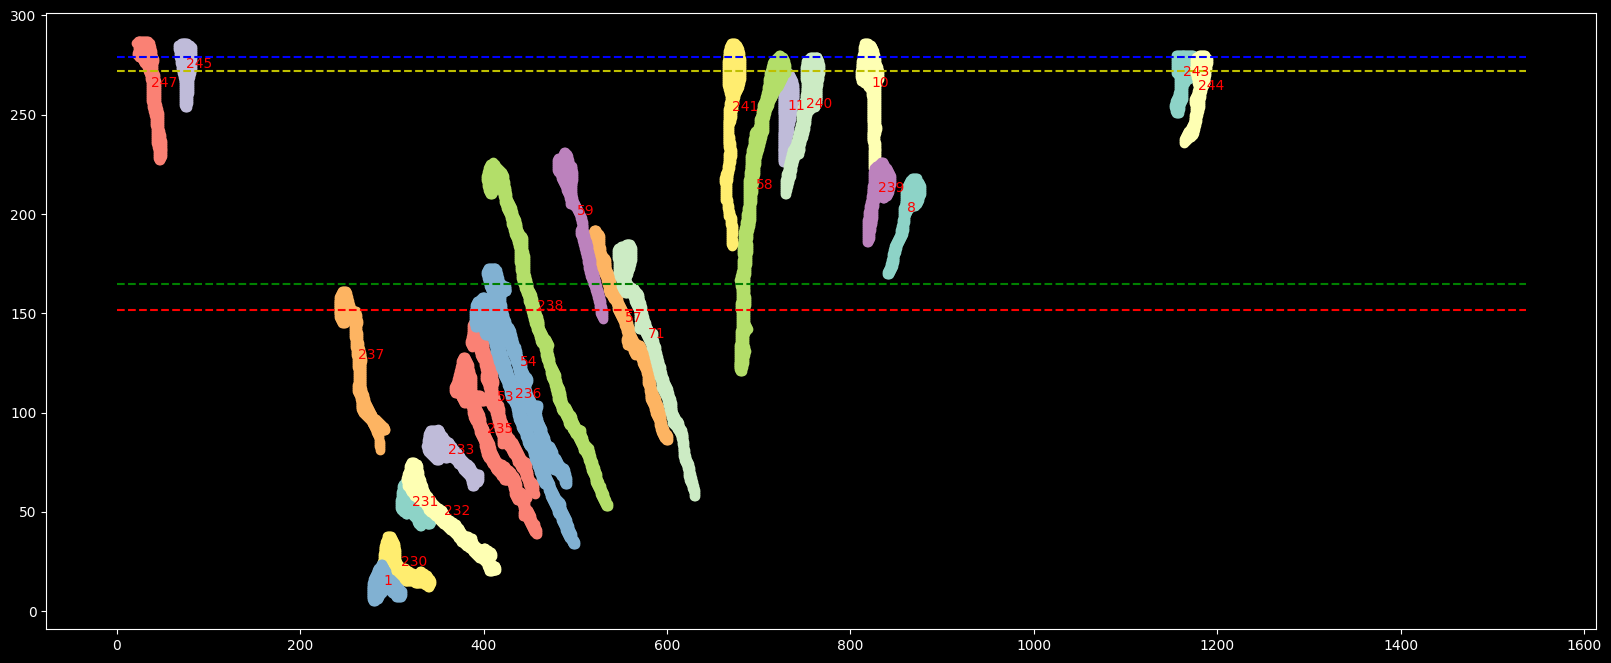

In [50]:
# Plot upper and lower regions

fig, ax = plt.subplots(figsize=(20, 8))

# Plot upper regions
means_upper = []
ax.set_title('Upper and Lower Regions')
for label in upper:
    region = np.where(masks == label)
    region = get_formated_region_coords(region)
    means_upper.append(np.mean(region, axis=0))
    ax.scatter(region[:, 0], region[:, 1])
    plt.text(np.mean(region[:, 0]), np.mean(region[:, 1]), str(label), fontsize=10, color='red')
median_upper = np.median(means_upper, axis=0)
mean_upper = np.mean(means_upper, axis=0)
plt.hlines(mean_upper[1], 0, masks.shape[1], colors='g', linestyles='dashed')
plt.hlines(median_upper[1], 0, masks.shape[1], colors='r', linestyles='dashed')

plt.show()


fig, ax = plt.subplots(figsize=(20, 8))
means_lower = []
# Plot lower regions
for label in lower:
    region = np.where(masks == label)
    region = get_formated_region_coords(region)
    means_lower.append(np.mean(region, axis=0))
    ax.scatter(region[:, 0], region[:, 1])
    plt.text(np.mean(region[:, 0]), np.mean(region[:, 1]), str(label), fontsize=10, color='red')
median_lower = np.median(means_lower, axis=0)
mean_lower = np.mean(means_lower, axis=0)
plt.hlines(median_lower[1], 0, masks.shape[1], colors='r', linestyles='dashed')
plt.hlines(mean_lower[1], 0, masks.shape[1], colors='g', linestyles='dashed')
cut_line = int((mean_upper[1] + mean_lower[1]) / 2)
cut_line_median = int((median_upper[1] + median_lower[1]) / 2)
plt.hlines(cut_line, 0, masks.shape[1], colors='b', linestyles='dashed')
plt.hlines(cut_line_median, 0, masks.shape[1], colors='y', linestyles='dashed')
plt.show()
# line_label, body = get_line(upper, masks,True)

# line = np.array([x[0] for x in line_label])
# line = np.array(line)
# sorted_indices = np.argsort(line[:, 0])
# line = line[sorted_indices]

# best_degree, best_r_score, best_mse, best_coefficients = best_fit_polynomial(line)

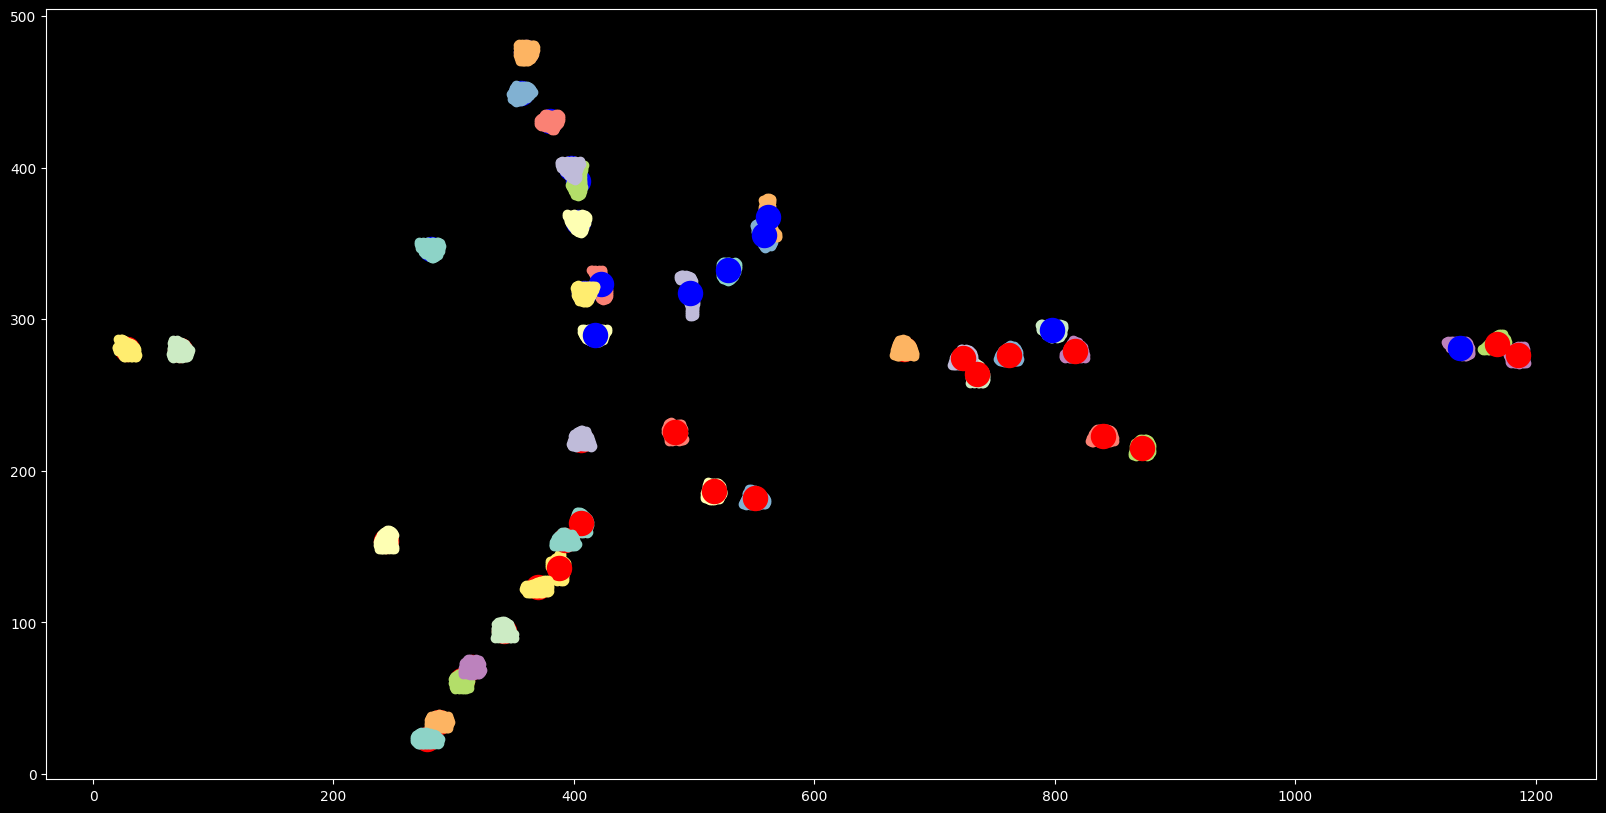

In [51]:
line_upper, body_upper = get_line(upper, masks,True,30)
line_lower, body_lower = get_line(lower, masks,False,30)

plt.figure(figsize=(20, 10))

for i in range(len(line_upper)):
    plt.scatter(body_upper[i][:, 0], body_upper[i][:, 1])

    plt.scatter(line_upper[i][0][0], line_upper[i][0][1], c='b', s=300)


for i in range(len(line_lower)):
    plt.scatter(body_lower[i][:, 0], body_lower[i][:, 1])
    plt.scatter(line_lower[i][0][0], line_lower[i][0][1], c='r', s=300)


plt.show()

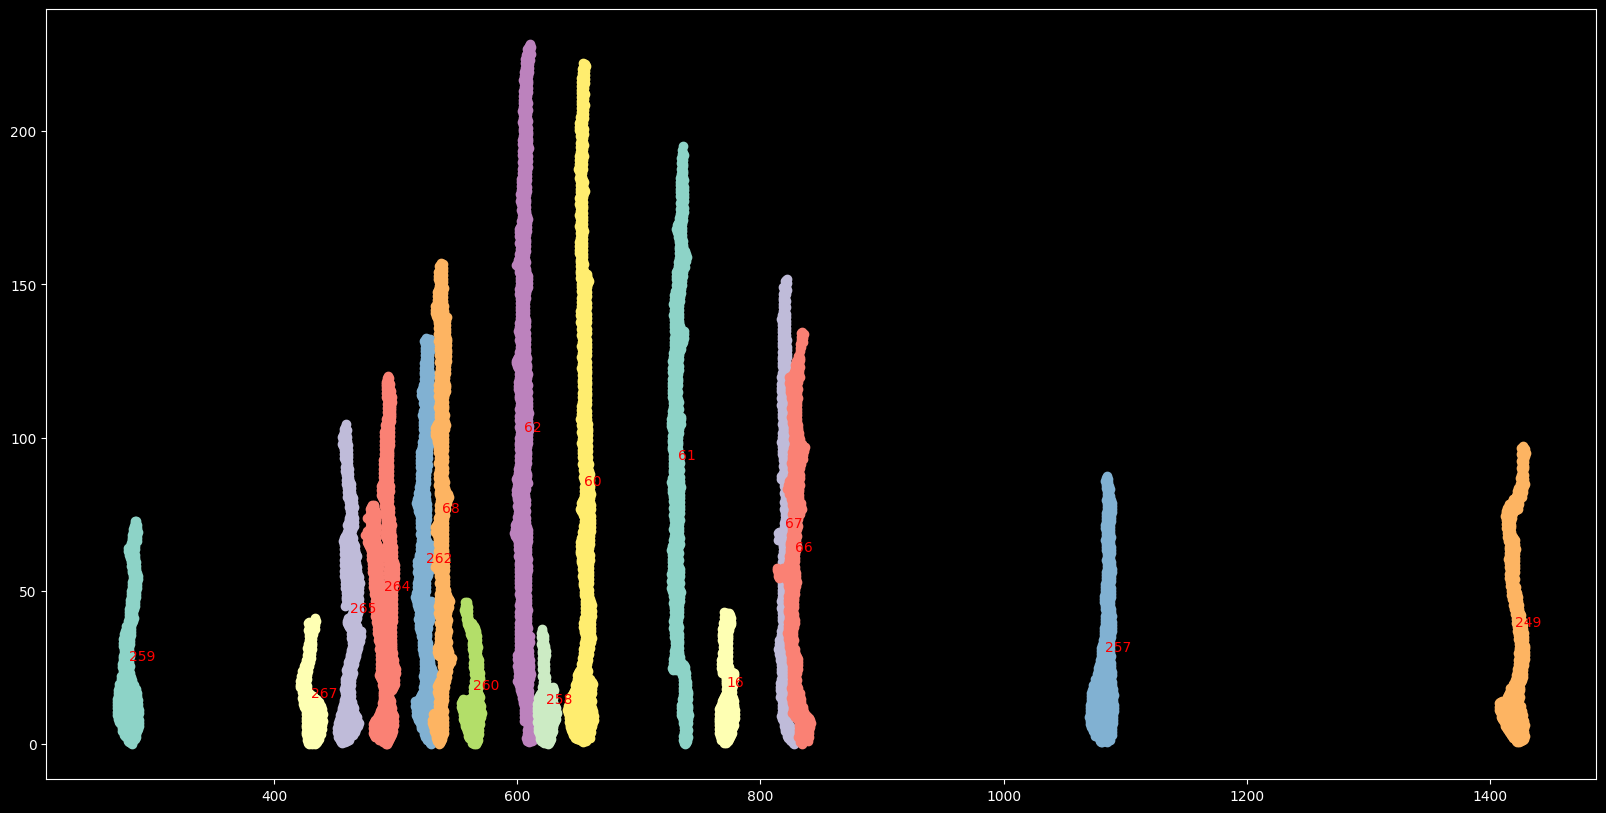

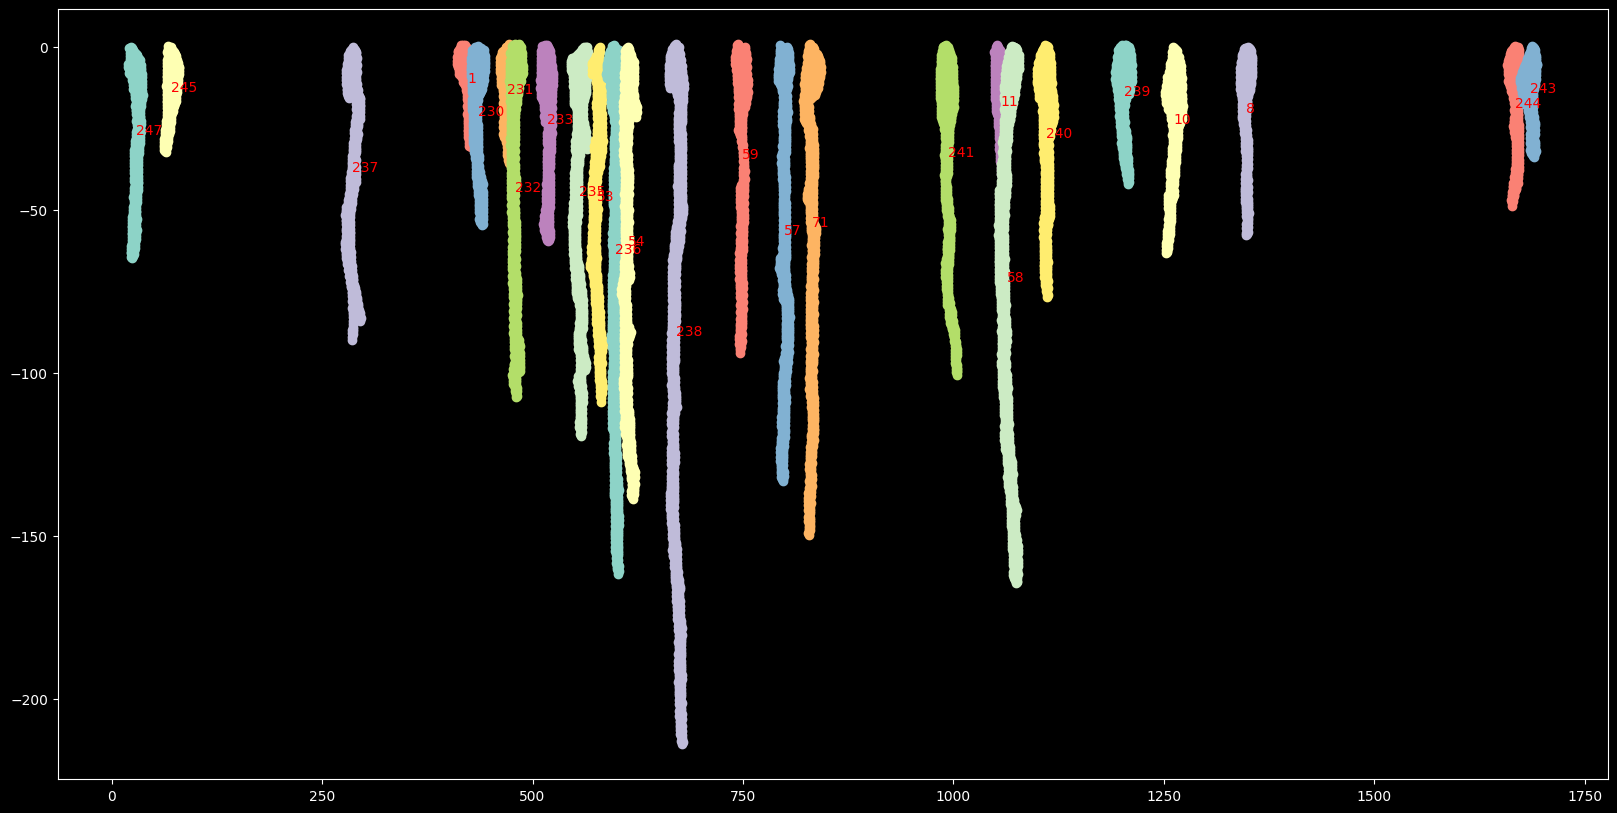

In [52]:
aligned_upper = align_regions(line_upper, masks, True)
aligned_lower = align_regions(line_lower, masks, False)

plt.figure(figsize=(20, 10))
i =0
for up in aligned_upper:
    plt.scatter(up[:, 0], up[:, 1])
    plt.text(np.mean(up[:, 0]), np.mean(up[:, 1]), str(line_upper[i][1]), fontsize=10, color='red')
    i+=1

plt.show()
i = 0
plt.figure(figsize=(20, 10))
for low in aligned_lower:
    plt.scatter(low[:, 0], low[:, 1])
    plt.text(np.mean(low[:, 0]), np.mean(low[:, 1]), str(line_lower[i][1]), fontsize=10, color='red')
    i+=1
plt.show()

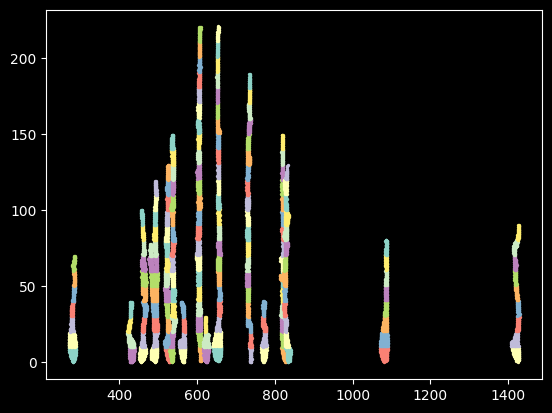

In [53]:
for region in aligned_upper:
    subsemgents = subsegment_region_y_axis(region, 10)
    visualize_subsegments(subsemgents)
plt.show()

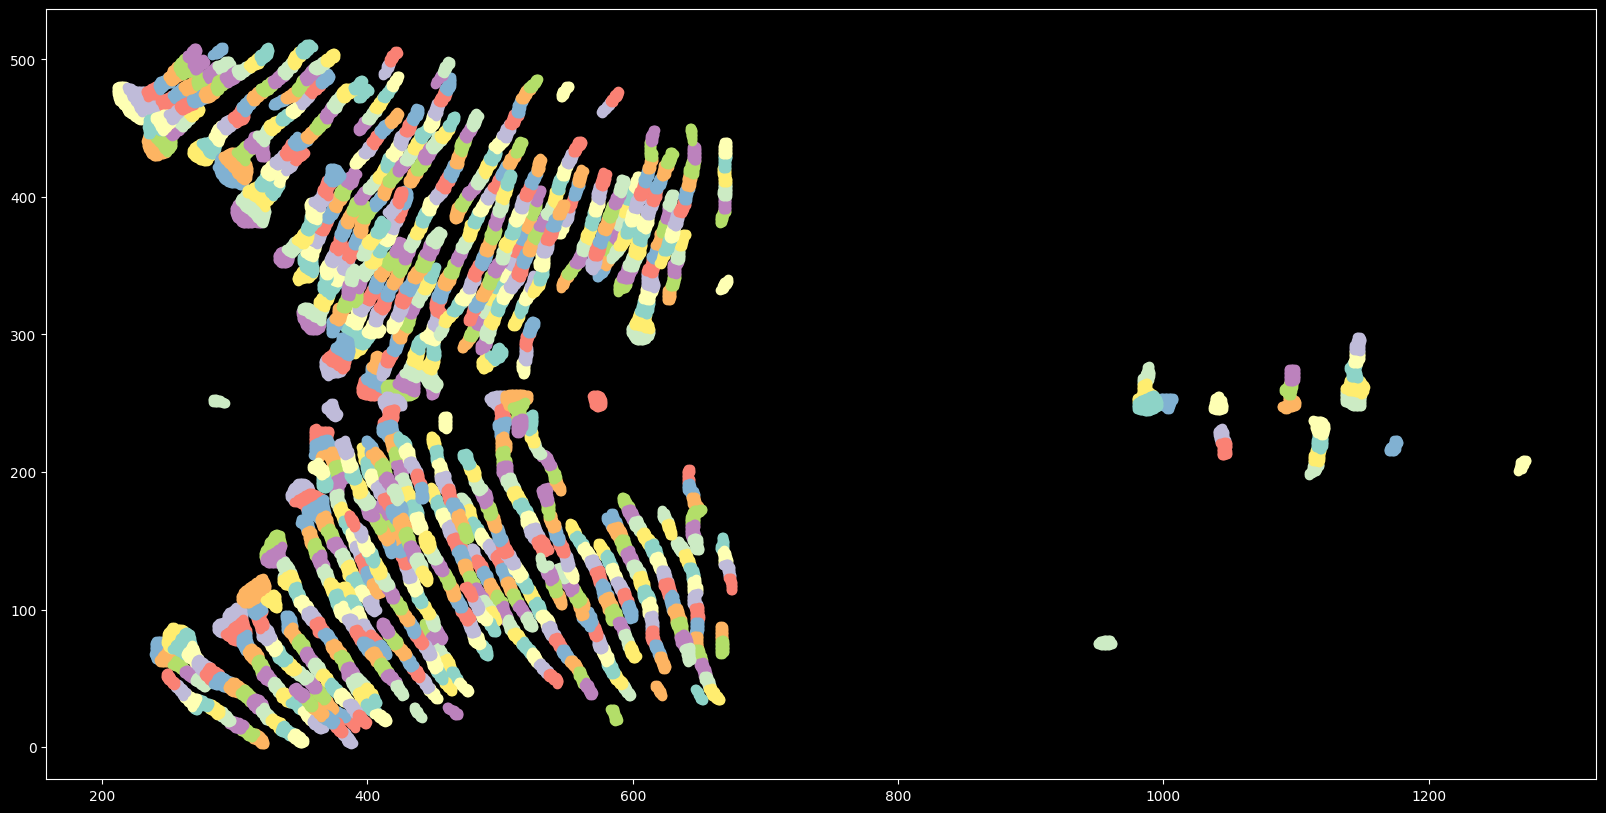

In [54]:
path = r"C:\Users\javid.rezai\YaksiLab\subsegmented_masks_seg.npy"

mask_file = np.load(path, allow_pickle=True).item()
masks = mask_file['masks']

labels = np.unique(masks)
labels = labels[labels != 0]
plt.figure(figsize=(20, 10))
for label in labels:
    region = np.where(masks == label)
    region = get_formated_region_coords(region)
    plt.scatter(region[:, 0], region[:, 1])
    # plt.text(region[0][0], region[0][1], str(label),fontsize=8,c='r')

plt.show()